<h1 align=center><font size = 5>Swin-Transformer </h1 >


<h3>Objective for this Notebook</h3>    
<h5> 1. 了解Swin-Transformer模型的架構</h5>
<h5> 2. 了解不同的功能是如何以程式碼實現</h5>
<h5> 3. 能夠將該模型應用到不同的任務</h5>   



# Table of Contents
<li><a href="#ref0">Swin-Transformer模型架構</a></li>
<li><a href="#ref1"><span style="color: lightgreen;">圖像分類</span></a></li>


<hr>


<a id="ref0"></a>
<h2 align=center>Swin-Transformer模型架構  </h2>


Swin-Transformer的一個Block由多個功能組成，包含了對於資料的細節處理，例如:Window-partition、Patch-Merging等，以及窗口多頭注意力計算(W-MSA)和移動窗口多頭注意力計算(SW-MSA)，還有最後的輸出MLP。基礎的Swin-Transformer是設計來處理圖像分類任務，而只要經過修改，Swin-Transformer也可以處理其他的下游任務。

<h3>主要由這些組成</h3>
<li><a href="#ref5">WindowAttention</a></li>
<li><a href="#ref6">Mlp</a></li>
<li><a href="#ref7">window_partition</a></li>
<li><a href="#ref8">window_reverse</a></li>
<li><a href="#ref9">SwinTransformerBlock</a></li>
<li><a href="#ref10">PatchMerging</a></li>
<li><a href="#ref11">PatchEmbed</a></li>
<li><a href="#ref12">BasicLayer</a></li>
<li><a href="#ref13">SwinTransformer</a></li>

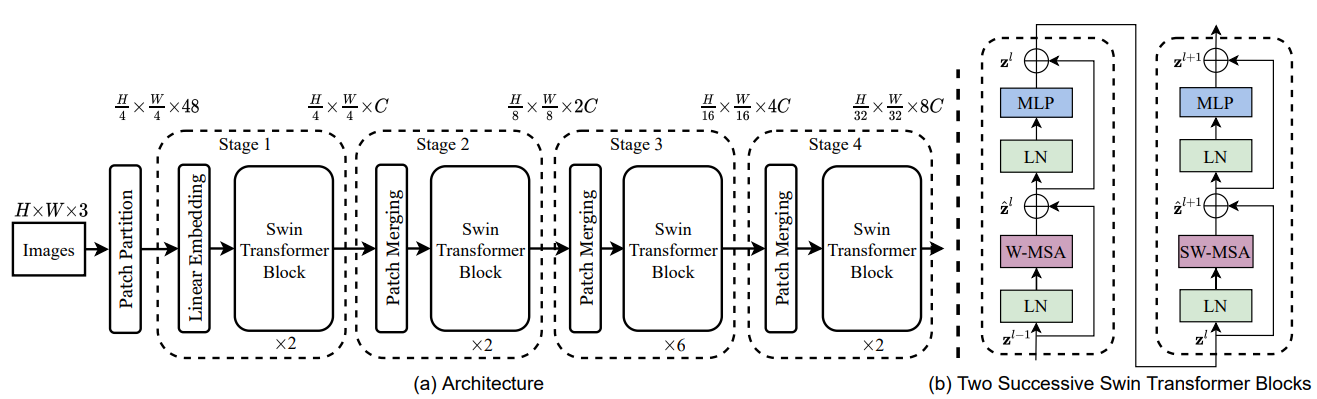

導入必要套件

In [3]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

c:\Users\tony1\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\tony1\anaconda3\envs\pytorch\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


<a id="ref5"></a>
<h3 align=center>WindowAttention  </h3>


主要功能

- 在局部窗口中計算多頭自注意力（W-MSA）。

初始化參數

- **`dim`**: 特徵向量的通道數，即輸入張量的最後一維大小。
- **`window_size`**: 窗口的高與寬，表示局部窗口的範圍。
- **`num_heads`**: 注意力頭的數量。
- **`qkv_bias`**: 決定是否對 Query、Key、Value 添加可學習的偏置。
- **`qk_scale`**: 指定 $q⋅k^T$ 的縮放因子。
- **`attn_drop` 和 `proj_drop`**: 分別為注意力權重和輸出層的 Dropout 機率。

輸入

**`x`**：輸入特徵，形狀為 `(num_windows * B, N, C)`。

返回值

**`x`**：張量，形狀為`(B, N, C)`。

In [4]:
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        #假設窗口大小為 window_size=(7,7)，則總共有 7×7=49 個位置。
        #每兩個位置的相對位置範圍為 [−6,6]，因此需要存儲 (2×7−1)×(2×7−1)=13×13=169 個相對偏置。
        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        

        #相對索引計算
        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        #生成 Query、Key 和 Value
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        #輸入特徵投影到 Q, K, V 空間
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        #對 Q 應用縮放，計算注意力分數
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        #添加相對位置偏置
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)
        #應用mask（可選）並通過 Softmax 將分數轉換為概率分佈
        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        #加權值向量得到輸出特徵，並重投影回原特徵空間
        attn = self.attn_drop(attn) #(B_, num_heads, N, C // num_heads)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

<a id="ref6"></a>
<h3 align=center>Mlp  </h3>


主要功能

- 作為最後的輸出頭。

初始化參數

- **`in_features`**：輸入特徵的維度。
- **`hidden_features`**：隱藏層的特徵維度，默認與輸入維度相同。
- **`out_features`**：輸出特徵的維度，默認與輸入維度相同。
- **`act_layer=nn.GELU`**：激活函數，默認使用 GELU（Gaussian Error Linear Unit）。
- **`drop=0.0`**：Dropout 的概率，默認為 0（即不使用 Dropout）。
- **`super().__init__()`**：調用父類的初始化方法，確保 `nn.Module` 的基本屬性被正確設置。

輸入

**`x`**：輸入張量，形狀為 `(B, C)`。

### 返回值

**`x`**：張量，形狀為`(B, C)`。

In [5]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        #若 hidden_features 或 out_features 未指定，則默認設置為與輸入維度相同。
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer() #GELU
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

<a id="ref7"></a>
<h3 align=center>window_partition  </h3>


主要功能

- 將特徵圖分割成多個窗口。 (tips：先是分成patch再來才是window)

初始化參數

- `x`：輸入的特徵圖，形狀為 `(B, H, W, C)`：
    - `B`：批次大小（Batch size）。
    - `H` 和 `W`：特徵圖的高度和寬度。
    - `C`：通道數。
- `window_size`：窗口的大小（正方形的邊長）。

輸入

**`x`**：輸入張量，形狀為 `(B, H, W, C)`。

返回值

**`x`**：張量，形狀為`(num_windows * B, window_size, window_size, C)`。

In [6]:
def window_partition(x, window_size):
    #將輸入x分別讀取出參數
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C) #(1, 8//4, 4, 8//4, 4, 3)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C) #(4, 4, 4, 3) num_windows(4) * Batch size(1)=4
    return windows

<a id="ref8"></a>
<h3 align=center>window_reverse  </h3>


主要功能

- 將分割後的特徵圖還原為原始圖像。

初始化參數

- **`windows`**: 形狀為 `(num_windows*B, window_size, window_size, C)` 的張量，表示分割後的窗口。
- **`window_size`**: 窗口大小。
- **`H` 和 `W`**: 圖像的高度和寬度。

輸入

**`x`**：輸入張量，形狀為 `(num_windows*B, window_size, window_size, C)`。

返回值

**`x`**：張量，形狀為`(B, H, W, C)`。

In [7]:
def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

<a id="ref9"></a>
<h3 align=center>SwinTransformerBlock  </h3>


主要功能

- 構成Swin Transformer 的基本區塊。

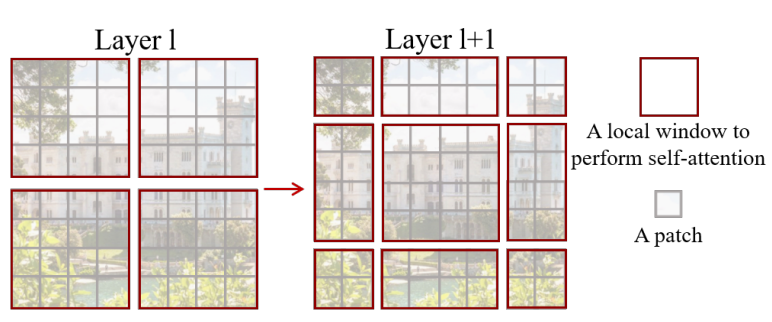

初始化參數

- `dim`: 輸入 Token 的嵌入維度。
- `input_resolution`: 輸入的空間解析度（高度 H 和寬度 W）。
- `num_heads`: 多頭注意力的頭數。
- `window_size`: 本地窗口大小，用於將輸入切分成小塊進行注意力計算。
- `shift_size`: 滑動窗口的偏移大小，用於 SW-MSA。
- `mlp_ratio`: MLP 隱藏層的維度比例（與嵌入維度相比）。

輸入

**`x`**：輸入張量，形狀為 `(B, H * W, C)`。

返回值

**`x`**：張量，形狀為`(B, H * W, C)`。


調用的其他類別、函式
<li><a href="#ref5">WindowAttention</a></li>
<li><a href="#ref6">Mlp</a></li>
<li><a href="#ref7">window_partition</a></li>
<li><a href="#ref8">window_reverse</a></li>


In [8]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        #確保window_size比圖片解析度大、參數正確
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        #計算 SW-MSA 的遮罩
        if self.shift_size > 0: #是否需要使用滑動窗口
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1 #用來記錄每個滑動窗口的分配情況
            #將特徵圖分割成對應的窗口區域
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            #將特徵圖分割成對應的窗口區域
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices: #將每個窗口區域的對應位置填上遞增的數字 cnt。
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size) #(nW,window_size×window_size) nW是窗口總數
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            #差值不為 0 的位置代表跨窗口，設為 −100.0 
            #差值為 0 的位置代表同窗口內 Token，設為 0.0 #(nW,window_size^2 ,window_size^2 )
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0)) 
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask) #一個靜態的張量，通過 register_buffer 儲存在模型中，不會作為參數更新

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift 滑動窗口處理
        if self.shift_size > 0:
            #將x進行循環移動（torch.roll）負值表示向左/上移動
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2)) 
            # partition windows
            x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        else: #不進行滑動，直接對 x 進行窗口劃分。
            shifted_x = x
            # partition windows
            x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C

        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA 每個窗口分別計算注意力
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C #mask=提前計算好的遮罩

        # merge windows 再合併窗口
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)

        # reverse cyclic shift 還原為原本的輸入
        if self.shift_size > 0:
            shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
            x = shifted_x

        
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)

        # FFN
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

<a id="ref10"></a>
<h3 align=center>PatchMerging   </h3>


主要功能

- 合併相鄰像素的特徵，減少分辨率並增加通道數。

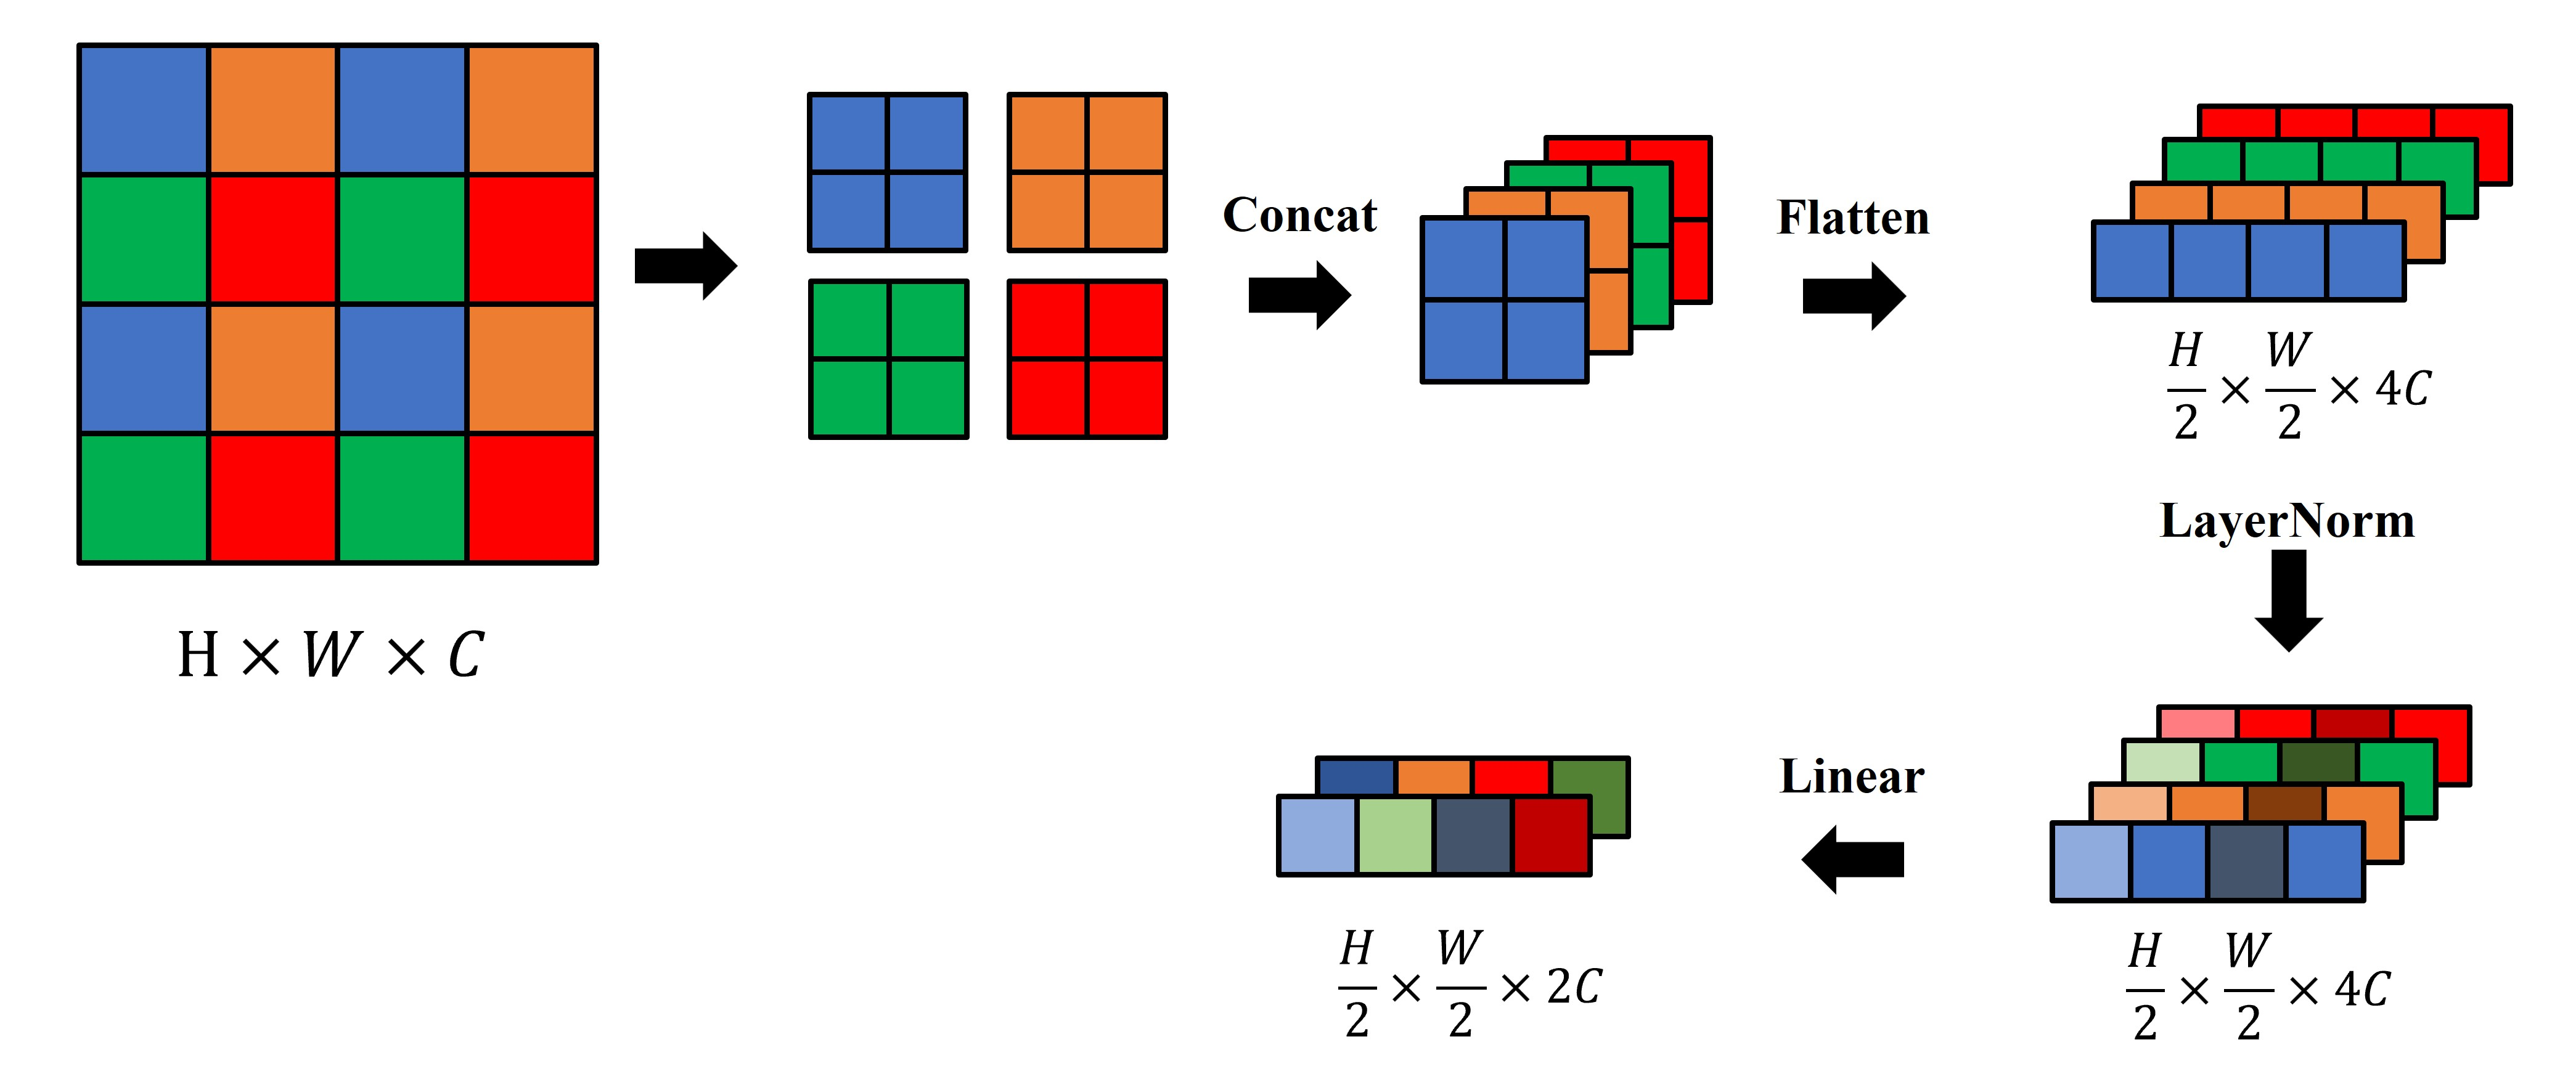

初始化參數

- **`input_resolution`**: 輸入特徵的解析度 `(H, W)`，即特徵圖的高度和寬度。
- **`dim`**: 輸入通道數。
- **`norm_layer`**: 使用的正則化層，默認為 `nn.LayerNorm`。

輸入

**`x`**：輸入張量，形狀為 `(B, H * W, C)`。

返回值

**`x`**：張量，形狀為`(B, H/2 * W/2, C)`。

In [9]:
class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False) #一個全連接層，將4C變成2C
        self.norm = norm_layer(4 * dim) #LayerNorm

    def forward(self, x):
        #檢查輸入形狀
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."
        #還原成二維形狀
        x = x.view(B, H, W, C)
        #提取四個子窗口 圖片中的第二步
        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C #從第 0 個位置開始，步長為2，選取 0, 2
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        """
            假設原本x是
            [[[ 0.,  1.,  2.,  3.], 
            [ 4.,  5.,  6.,  7.],
            [ 8.,  9., 10., 11.],
            [12., 13., 14., 15.]]]  
            #第一個高度 0::2 選0,2 rows 
            [[ 0.,  1.,  2.,  3.], 
            [ 8.,  9., 10., 11.]]
            #第二個是寬度 0::2 選0,2 columns
            [[ 0.,  2.], 
            [ 8., 10.]]
        """
        #拼接窗口 圖片中的第三步
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        #重塑為展平形狀 圖片中的第四步
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C
        #Normalize與降維 圖片中的第五、六步
        x = self.norm(x)
        x = self.reduction(x) # 降維到 2*C

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops

<a id="ref11"></a>
<h3 align=center>PatchEmbed    </h3>


主要功能

- 將圖像分割成小區塊（Patch），並對每個 Patch 進行嵌入映射。


初始化參數

- `img_size`: 輸入影像的大小，預設為 224。
- `patch_size`: 每個 Patch 的大小，預設為 4。
- `in_chans`: 輸入影像的通道數，預設為 3（例如 RGB）。
- `embed_dim`: 對每個 Patch 的嵌入向量維度，預設為 96。
- `norm_layer`: 用於標準化的層（LayerNorm 或其他），預設為 `None`。

輸入

**`x`**：輸入張量，形狀為 `(B, C, H, W)`。

返回值

**`x`**：張量，形狀為`(B, Ph*Pw, embed_dim)`。

In [10]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) #(224) to (224,224)
        patch_size = to_2tuple(patch_size) #(4) to (4,4)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] #[0,1] = [56,56]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution #[56,56]
        self.num_patches = patches_resolution[0] * patches_resolution[1] #3136

        self.in_chans = in_chans
        self.embed_dim = embed_dim
        #將圖像分割成 Patch 並投影到 embed_dim 維度。
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)#(3,96,4,4)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        #將圖片分割後投影(1, 96, 56, 56)；展平(1, 96, 3136)；第二維第三維互換(1, 3136, 96)
        x = self.proj(x).flatten(2).transpose(1, 2)  #(B, Ph*Pw, embed_dim)
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops

<a id="ref12"></a>
<h3 align=center>BasicLayer    </h3>


主要功能

- 實現 Swin Transformer 的基本層。


初始化參數

- `dim`: 嵌入維度，即每個輸入 Token 的特徵維度。
- `input_resolution`: 輸入特徵的空間分辨率（`H x W`）。
- `depth`: 該層包含的 Swin Transformer 區塊數量。
- `num_heads`: 多頭注意力的頭數。
- `window_size`: 每個區域的局部窗口大小。
- `downsample`: 是否應用下采樣操作以減少空間分辨率。
- `use_checkpoint`: 是否啟用檢查點技術節省記憶體。

輸入

**`x`**：輸入張量，形狀為 `(B, H * W, C)`。

返回值

**`x`**：張量，形狀為`(B, N, C)`。


調用的其他類別、函式
<li><a href="#ref9">SwinTransformerBlock</a></li>
<li><a href="#ref10">PatchMerging</a></li>


In [11]:
class BasicLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False
                 ):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks 建立 Swin Transformer block
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer
                                 )
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        #依次執行每個 SwinTransformerBlock
        for blk in self.blocks:
            if self.use_checkpoint: #用來節省記憶體
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

<a id="ref13"></a>
<h3 align=center>SwinTransformer    </h3>


主要功能

- Swin Transformer 的整體架構。


初始化參數

- **`img_size`**: 輸入圖像的尺寸，默認為 224×224。
- **`patch_size`**: 分割圖像的每個小區域（patch）尺寸，默認為 4×4。
- **`in_chans`**: 輸入圖像的通道數，默認為 3（RGB）。
- **`num_classes`**: 最終分類的類別數，默認為 1000（對應 ImageNet）。
- **`embed_dim`**: 嵌入的基礎維度，默認為 96。
- **`depths`**: 每層的 Transformer 模塊數，分別默認為 [2, 2, 6, 2]。
- **`num_heads`**: 每層多頭注意力機制的頭數，分別默認為 [3, 6, 12, 24]。
- **`window_size`**: 局部注意力窗口大小，默認為 7。
- **`mlp_ratio`**: MLP 隱藏層與輸入維度的比率，默認為 4。
- **`qkv_bias`**: 是否為 QKV 添加偏差項。
- **`drop_rate`**: 隨機丟棄率。
- **`attn_drop_rate`**: 注意力機制中的丟棄率。
- **`drop_path_rate`**: 隨機深度丟棄率。
- **`norm_layer`**: 用於正規化的層，默認為 `LayerNorm`。
- **`ape`**: 是否啟用絕對位置編碼。
- **`patch_norm`**: 是否在 Patch 嵌入後進行正規化。
- **`use_checkpoint`**: 是否啟用檢查點，用於節省顯存。

輸入

**`x`**：輸入張量，形狀為 `(B, H * W, C)`。

返回值

**`x`**：張量，形狀為`(B, N, C)`。


調用的其他類別、函式
<li><a href="#ref10">PatchMerging</a></li>
<li><a href="#ref11">PatchEmbed</a></li>
<li><a href="#ref12">BasicLayer</a></li>

In [12]:
class SwinTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths) #2 2 6 2
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1)) #最後一層輸出的嵌入維度
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers 建構SwinTransformer
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint
                               )
            self.layers.append(layer)
            
        #最終分類
        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x) #將輸入影像 x 經過 PatchEmbed (B, L, C) L 是總 patch 數
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        #依次通過每個 Swin Transformer 層進行特徵提取
        for layer in self.layers:
            x = layer(x) #BasicLayer

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  #(B, L, C) 轉換為 (B, C, L)  將特徵的序列維度壓縮為固定的單一值1 (B C 1)
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

<a id="ref1"></a>
<h2 align=center>圖像分類  </h2>


In [13]:
# Check cuda is working
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [50]:
model = SwinTransformer(num_classes=10).to(device)

In [51]:
import torchvision
from torchvision import transforms
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [52]:
# Download CIFAR100 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root=".", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root=".", train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [53]:
import random
random.seed(42)
train_size = int(0.8 * len(train_dataset))  # 80%
val_size = len(train_dataset) - train_size  # 20%
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

In [54]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [56]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
class Trainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        criterion,
        optimizer,
        epochs,
        device=None,  # 新增設備參數
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train(self):
        self.model.train()
        start_time = time.time()  # 記錄訓練開始時間
        for epoch in range(self.epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in tqdm(
                self.train_loader, desc=f"Epoch {epoch + 1}/{self.epochs} Training"
            ):
                inputs = inputs.float().to(self.device)  # 確保是 float
                labels = labels.to(self.device)
                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)  # y-yhat

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Track loss
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Calculate average loss and accuracy
            avg_loss = running_loss / len(self.train_loader)
            accuracy = 100 * correct / total

            # Store the loss and accuracy
            self.train_losses.append(avg_loss)
            self.train_accuracies.append(accuracy)

            print(
                f"Epoch [{epoch + 1}/{self.epochs}], Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.2f}%"
            )

            # Validation after each epoch
            val_loss, val_accuracy = self.validate()
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            print(
                f"Epoch [{epoch + 1}/{self.epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%"
            )

        end_time = time.time()  # 記錄訓練結束時間
        total_time = end_time - start_time  # 計算總訓練時間
        print(f"Total Training Time: {total_time:.2f} seconds")

    def validate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(self.val_loader, desc="Validating"):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(self.val_loader)
        accuracy = 100 * correct / total
        return avg_val_loss, accuracy

    def plot_graphs(self):
        epochs = range(1, self.epochs + 1)

        # Plot training & validation loss values
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Training Loss")
        plt.plot(epochs, self.val_losses, label="Validation Loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label="Training Accuracy")
        plt.plot(epochs, self.val_accuracies, label="Validation Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy (%)")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def test(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(self.test_loader, desc="Testing"):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")

In [57]:
# Initialize the trainer
trainer = Trainer(
    model,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=10,  # Adjusted epochs to see the trends better
    device=device,
)

In [25]:
trainer.train()

Epoch 1/10 Training: 100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


Epoch [1/10], Training Loss: 1.9847, Training Accuracy: 28.86%


Validating: 100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


Epoch [1/10], Validation Loss: 1.6475, Validation Accuracy: 38.06%


Epoch 2/10 Training: 100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


Epoch [2/10], Training Loss: 1.4620, Training Accuracy: 46.32%


Validating: 100%|██████████| 79/79 [00:18<00:00,  4.29it/s]


Epoch [2/10], Validation Loss: 1.2977, Validation Accuracy: 52.72%


Epoch 3/10 Training: 100%|██████████| 313/313 [02:49<00:00,  1.85it/s]


Epoch [3/10], Training Loss: 1.1845, Training Accuracy: 56.95%


Validating: 100%|██████████| 79/79 [00:19<00:00,  4.10it/s]


Epoch [3/10], Validation Loss: 1.1441, Validation Accuracy: 59.78%


Epoch 4/10 Training: 100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


Epoch [4/10], Training Loss: 1.0112, Training Accuracy: 63.63%


Validating: 100%|██████████| 79/79 [00:18<00:00,  4.18it/s]


Epoch [4/10], Validation Loss: 0.9859, Validation Accuracy: 64.41%


Epoch 5/10 Training: 100%|██████████| 313/313 [02:54<00:00,  1.80it/s]


Epoch [5/10], Training Loss: 0.8729, Training Accuracy: 68.89%


Validating: 100%|██████████| 79/79 [00:21<00:00,  3.69it/s]


Epoch [5/10], Validation Loss: 0.9218, Validation Accuracy: 67.12%


Epoch 6/10 Training: 100%|██████████| 313/313 [03:00<00:00,  1.74it/s]


Epoch [6/10], Training Loss: 0.7423, Training Accuracy: 73.62%


Validating: 100%|██████████| 79/79 [00:25<00:00,  3.16it/s]


Epoch [6/10], Validation Loss: 0.8675, Validation Accuracy: 69.38%


Epoch 7/10 Training: 100%|██████████| 313/313 [03:10<00:00,  1.64it/s]


Epoch [7/10], Training Loss: 0.6394, Training Accuracy: 77.19%


Validating: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


Epoch [7/10], Validation Loss: 0.8277, Validation Accuracy: 71.15%


Epoch 8/10 Training: 100%|██████████| 313/313 [02:57<00:00,  1.76it/s]


Epoch [8/10], Training Loss: 0.5227, Training Accuracy: 81.37%


Validating: 100%|██████████| 79/79 [00:18<00:00,  4.21it/s]


Epoch [8/10], Validation Loss: 0.9496, Validation Accuracy: 68.58%


Epoch 9/10 Training: 100%|██████████| 313/313 [02:49<00:00,  1.85it/s]


Epoch [9/10], Training Loss: 0.4051, Training Accuracy: 85.69%


Validating: 100%|██████████| 79/79 [00:19<00:00,  4.09it/s]


Epoch [9/10], Validation Loss: 0.9309, Validation Accuracy: 70.39%


Epoch 10/10 Training: 100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


Epoch [10/10], Training Loss: 0.3069, Training Accuracy: 89.18%


Validating: 100%|██████████| 79/79 [00:19<00:00,  4.08it/s]

Epoch [10/10], Validation Loss: 1.0257, Validation Accuracy: 69.51%
Total Training Time: 1945.10 seconds


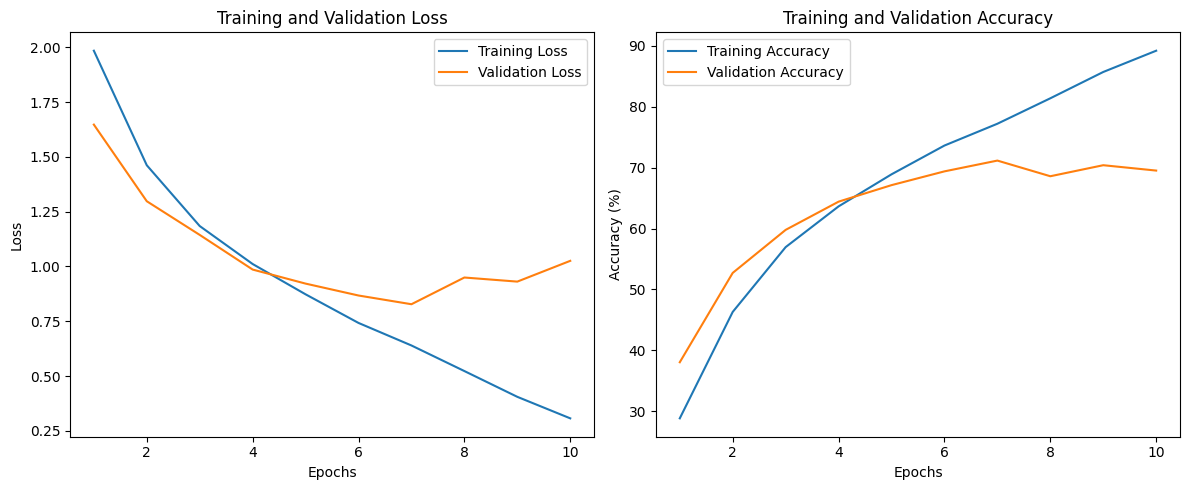

In [26]:
trainer.plot_graphs()

In [27]:
trainer.test()

Testing: 100%|██████████| 79/79 [00:19<00:00,  4.06it/s]

Test Accuracy: 68.33%


In [70]:
Swin_weights = model.state_dict()
weights_path = "swin_tiny_patch4_window7_224.pth" #https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth
pre_trained_weights = torch.load(weights_path, map_location=device)

if "model" in pre_trained_weights:
    pre_trained_weights = pre_trained_weights["model"]
elif "state_dict" in pre_trained_weights:
    pre_trained_weights = pre_trained_weights["state_dict"]

del_key = [key for key in pre_trained_weights.keys() if "head" in key]
for key in del_key:
    del pre_trained_weights[key]
missing_keys, unexpected_keys = model.load_state_dict(pre_trained_weights, strict=False)

print("missing_keys:", missing_keys)
print("unexpected_keys:", unexpected_keys)


missing_keys: ['head.weight', 'head.bias']
unexpected_keys: []


C:\Users\tony1\AppData\Local\Temp\ipykernel_37684\416007984.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre_trained_weights = torch.load(weights_path, map_location=d

In [58]:
# Initialize the trainer
trainer_load_weights = Trainer(
    model,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=10,  # Adjusted epochs to see the trends better
    device=device,
)

In [61]:
trainer_load_weights.train()

Epoch 1/10 Training: 100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


Epoch [1/10], Training Loss: 0.2676, Training Accuracy: 91.47%


Validating: 100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


Epoch [1/10], Validation Loss: 0.1378, Validation Accuracy: 95.19%


Epoch 2/10 Training: 100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


Epoch [2/10], Training Loss: 0.0608, Training Accuracy: 97.94%


Validating: 100%|██████████| 79/79 [00:19<00:00,  4.08it/s]


Epoch [2/10], Validation Loss: 0.0987, Validation Accuracy: 96.73%


Epoch 3/10 Training: 100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


Epoch [3/10], Training Loss: 0.0333, Training Accuracy: 98.87%


Validating: 100%|██████████| 79/79 [00:18<00:00,  4.34it/s]


Epoch [3/10], Validation Loss: 0.0992, Validation Accuracy: 96.88%


Epoch 4/10 Training: 100%|██████████| 313/313 [02:37<00:00,  1.99it/s]


Epoch [4/10], Training Loss: 0.0236, Training Accuracy: 99.21%


Validating: 100%|██████████| 79/79 [00:18<00:00,  4.33it/s]


Epoch [4/10], Validation Loss: 0.1314, Validation Accuracy: 96.27%


Epoch 5/10 Training: 100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


Epoch [5/10], Training Loss: 0.0231, Training Accuracy: 99.23%


Validating: 100%|██████████| 79/79 [00:17<00:00,  4.41it/s]


Epoch [5/10], Validation Loss: 0.1267, Validation Accuracy: 96.37%


Epoch 6/10 Training: 100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


Epoch [6/10], Training Loss: 0.0206, Training Accuracy: 99.34%


Validating: 100%|██████████| 79/79 [00:18<00:00,  4.32it/s]


Epoch [6/10], Validation Loss: 0.1330, Validation Accuracy: 96.41%


Epoch 7/10 Training: 100%|██████████| 313/313 [02:37<00:00,  1.99it/s]


Epoch [7/10], Training Loss: 0.0132, Training Accuracy: 99.58%


Validating: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


Epoch [7/10], Validation Loss: 0.1309, Validation Accuracy: 96.74%


Epoch 8/10 Training: 100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


Epoch [8/10], Training Loss: 0.0186, Training Accuracy: 99.39%


Validating: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


Epoch [8/10], Validation Loss: 0.1516, Validation Accuracy: 96.23%


Epoch 9/10 Training: 100%|██████████| 313/313 [02:36<00:00,  2.01it/s]


Epoch [9/10], Training Loss: 0.0178, Training Accuracy: 99.41%


Validating: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]


Epoch [9/10], Validation Loss: 0.1347, Validation Accuracy: 96.46%


Epoch 10/10 Training: 100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


Epoch [10/10], Training Loss: 0.0160, Training Accuracy: 99.47%


Validating: 100%|██████████| 79/79 [00:18<00:00,  4.31it/s]

Epoch [10/10], Validation Loss: 0.1236, Validation Accuracy: 96.87%
Total Training Time: 1777.47 seconds


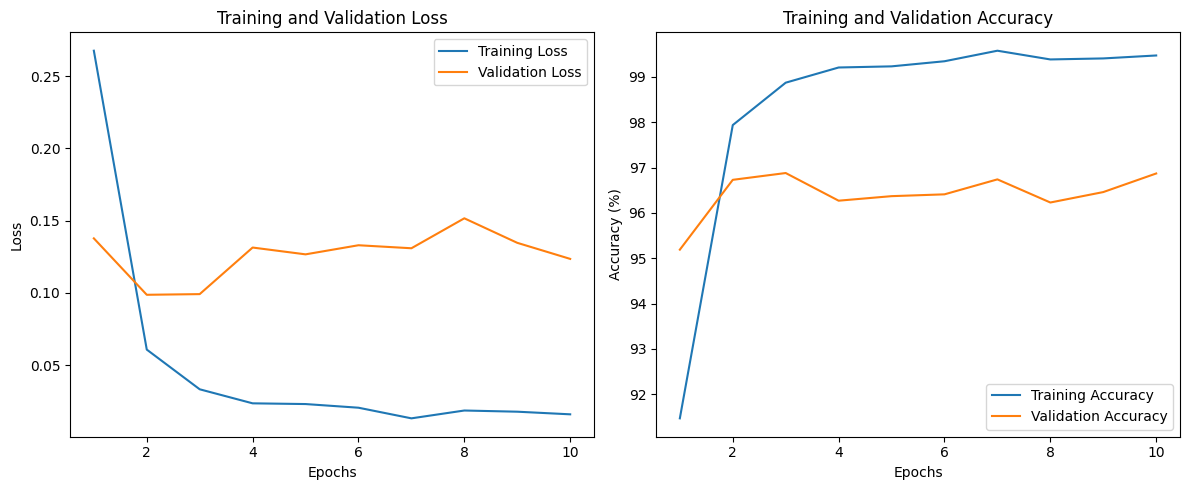

In [64]:
trainer_load_weights.plot_graphs()

In [62]:
trainer_load_weights.test()

Testing: 100%|██████████| 79/79 [00:18<00:00,  4.33it/s]

Test Accuracy: 96.72%


<a id="ref2"></a>
<h2 align=center>物件偵測  </h2>
